In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
import time

from utils import *

import pysindy as ps

# Ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
# np.random.seed(100)

In [2]:
t1 = time.time()

# Arneodo does not have the Lyapunov spectrum calculated so omit it.
# HindmarshRose and AtmosphericRegime seem to be poorly sampled
# by the dt and dominant time scales used in the database, so we omit them.
systems_list = ["Aizawa", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "Hadley",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices"
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    # print(i, equation_name, all_properties[equation_name])
    
n = 1000
pts_per_period = 100
n_trajectories = 5
# Get training and testing trajectories for all the experimental systems 
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list, all_properties, 
    n=n, pts_per_period=pts_per_period,
    random_bump=False,
    n_trajectories=n_trajectories
)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
2 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
3 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
4 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
5 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
6 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
7 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
8 GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
9 GuckenheimerHolmes(name='GuckenheimerHolmes', params={'a': 0.4, 'b': 20.25, 'c': 3, 'd': 1.6, 'e': 1.7, 'f': 0.44}, random_

In [3]:
num_attractors = len(systems_list)

lyap_list = []
dimension_list = []
param_list = []
# Calculate scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])
    
    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(all_properties[system]['period'] / all_properties[system]['dt'])


true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)
nonlinearities = nonlinear_terms_from_coefficients(true_coefficients)

# Want ratio of largest to smallest LINEAR or LYAPUNOV EXPONENT timescales 
for i, system in enumerate(systems_list):
    linear_coefs = true_coefficients[i][:, :dimension_list[i]] 
    max_linear = np.max(abs(linear_coefs))
    min_linear = np.min(abs(linear_coefs[linear_coefs != 0.0]))
    linear_scale_list.append(max_linear / min_linear)
    # print(all_properties[system]['lyapunov_spectrum_estimated'])
    sorted_spectrum = np.sort((np.array(all_properties[system]['lyapunov_spectrum_estimated'])))
    # print(sorted_spectrum, np.sum(np.array(sorted_spectrum > 0.0, dtype=int)))
    lambda_max = sorted_spectrum[-1]
    lambda_min = sorted_spectrum[0]

    #print(i, system, all_properties[system]['lyapunov_spectrum_estimated'])
    scale_list.append(lambda_max / lambda_min)
    # print(i, system, scale_list[i])


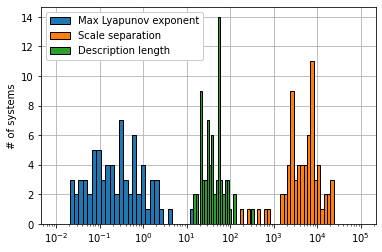

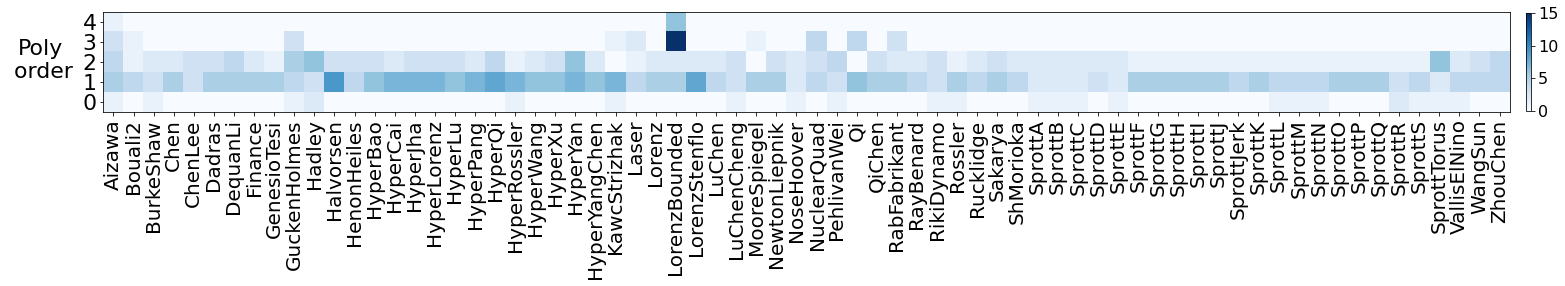

In [4]:
from complexity_calculator import compute_medl
from matplotlib.colors import LogNorm

medl_list = compute_medl(systems_list, all_sols_train, param_list)

systems_list_cleaned = []
for i, system in enumerate(systems_list):
    if system == "GuckenheimerHolmes":
        systems_list_cleaned.append("GuckenHolmes")
    elif system == "NuclearQuadrupole":
        systems_list_cleaned.append("NuclearQuad")
    elif system == "RabinovichFabrikant":
        systems_list_cleaned.append("RabFabrikant")
    elif system == "KawczynskiStrizhak":
        systems_list_cleaned.append("KawcStrizhak")
    elif system == "RikitakeDynamo":
        systems_list_cleaned.append("RikiDynamo")
    elif system == "ShimizuMorioka":
        systems_list_cleaned.append("ShMorioka")
    elif system == "HindmarshRose":
        systems_list_cleaned.append("Hindmarsh")
    elif system == "RayleighBenard":
        systems_list_cleaned.append("RayBenard")
    else:
        systems_list_cleaned.append(system)
    
plt.figure()
medl_levels = np.logspace(1, 3, 40)
lyap_levels = np.logspace(-2, 2, 40)
scale_levels = np.logspace(2, 5, 40)

plt.hist(lyap_list, bins=lyap_levels, ec='k') #, log=True)
plt.hist(scale_list_avg, bins=scale_levels, ec='k') #, log=True)
plt.hist(medl_list, bins=medl_levels, ec='k') #, log=True)
plt.xlabel('')
plt.ylabel('# of systems')
plt.legend(['Max Lyapunov exponent', 'Scale separation', 'Description length'],
           framealpha=1.0)
plt.xscale('log')
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True)
plt.savefig('metrics.pdf')

plt.figure(figsize=(30, 6))
plt.imshow(nonlinearities.T, aspect='equal', origin='lower', cmap='Blues')
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=20)
ax = plt.gca()
plt.xlim(-0.5, num_attractors - 0.5)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(np.arange(5), fontsize=22)
plt.colorbar(shrink=0.3, pad=0.01).ax.tick_params(labelsize=16)
plt.ylabel('Poly\n order', rotation=0, fontsize=22)
ax.yaxis.set_label_coords(-0.045, 0.3)
plt.savefig('nonlinearity.pdf')

In [5]:
import json
temp = open('xdot_rmse_error.json')
xdot_rmse_error = json.load(temp)

temp = open('xdot_coef_error.json')
xdot_coef_error = json.load(temp)

temp = open('predicted_coefficients.json')
predicted_coefficients = json.load(temp)

In [6]:
n_models = 10
for name in predicted_coefficients:
    predicted_coefficients[name] = np.asarray(predicted_coefficients[name])

# $R^2$ Check

In [7]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))

# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

In [8]:
from scipy.stats import linregress
from sklearn.metrics import r2_score

In [9]:
##################
# scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)

slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)

slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print("Scale Separation:")
print("scipy.stats.linregress:")
print("  R^2 value for RMSE error = ", r_value**2)
print("  R^2 value for coef error = ", r_value_coef**2)

r_value = r2_score(avg_rmse_error[scale_sort], slope * scale_list_sorted + intercept)
r_value_coef = r2_score(cerrs[scale_sort], slope_coef * scale_list_sorted + intercept_coef)

print("sklearn.metrics.r2_score:")
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)
print()

##################
# chaotic levels
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)

slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)

print("Chaotic levels:")
print("scipy.stats.linregress:")
print("  R^2 value for RMSE error = ", r_value**2)
print("  R^2 value for coef error = ", r_value_coef**2)

r_value = r2_score(avg_rmse_error[scale_sort], slope * scale_list_sorted + intercept)
r_value_coef = r2_score(cerrs[scale_sort], slope_coef * scale_list_sorted + intercept_coef)

print("sklearn.metrics.r2_score:")
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)
print()

##################
# description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)

print("description length:")
print("scipy.stats.linregress:")
print("  R^2 value for RMSE error = ", r_value**2)
print("  R^2 value for coef error = ", r_value_coef**2)

r_value = r2_score(avg_rmse_error[scale_sort], slope * scale_list_sorted + intercept)
r_value_coef = r2_score(cerrs[scale_sort], slope_coef * scale_list_sorted + intercept_coef)

print("sklearn.metrics.r2_score:")
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)
print()

##################
# amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)

print("amount of nonlinearity:")
print("scipy.stats.linregress:")
print("  R^2 value for RMSE error = ", r_value**2)
print("  R^2 value for coef error = ", r_value_coef**2)

r_value = r2_score(avg_rmse_error[scale_sort], slope * scale_list_sorted + intercept)
r_value_coef = r2_score(cerrs[scale_sort], slope_coef * scale_list_sorted + intercept_coef)

print("sklearn.metrics.r2_score:")
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

Scale Separation:
scipy.stats.linregress:
  R^2 value for RMSE error =  0.4381617392377593
  R^2 value for coef error =  0.10099261246034587
sklearn.metrics.r2_score:
  R^2 value for RMSE error =  0.4381617392377589
  R^2 value for coef error =  0.10099261246034541

Chaotic levels:
scipy.stats.linregress:
  R^2 value for RMSE error =  0.029509192395653236
  R^2 value for coef error =  0.0006984221057501749
sklearn.metrics.r2_score:
  R^2 value for RMSE error =  0.02950919239565364
  R^2 value for coef error =  0.0006984221057499962

description length:
scipy.stats.linregress:
  R^2 value for RMSE error =  0.21053699594352424
  R^2 value for coef error =  0.030329458399641088
sklearn.metrics.r2_score:
  R^2 value for RMSE error =  0.21053699594352415
  R^2 value for coef error =  0.030329458399641185

amount of nonlinearity:
scipy.stats.linregress:
  R^2 value for RMSE error =  0.2178331391558789
  R^2 value for coef error =  0.034025753811637666
sklearn.metrics.r2_score:
  R^2 value fo

# $R^2$ from scikit-learn without sample weight

In [10]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))

In [11]:
# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

In [12]:
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score

Scale Separation:
  [1.20153706e-06] 0.008071253637439966
  R^2 value for RMSE error =  0.43816173923775903
  R^2 value for coef error =  0.04969909057072586
Chaotic Levels:
  [0.00093879] 0.015124376884715763
  R^2 value for RMSE error =  0.02950919239565364
  R^2 value for coef error =  -0.08562125831105516
Description Length:
  [0.00010414] 0.010563203794253802
  R^2 value for RMSE error =  0.21053699594352415
  R^2 value for coef error =  0.06339453622642455
Amount of Nonlinearity:
  [0.00036215] 0.0089062953357215
  R^2 value for RMSE error =  0.21783313915587899
  R^2 value for coef error =  0.057884176842889934


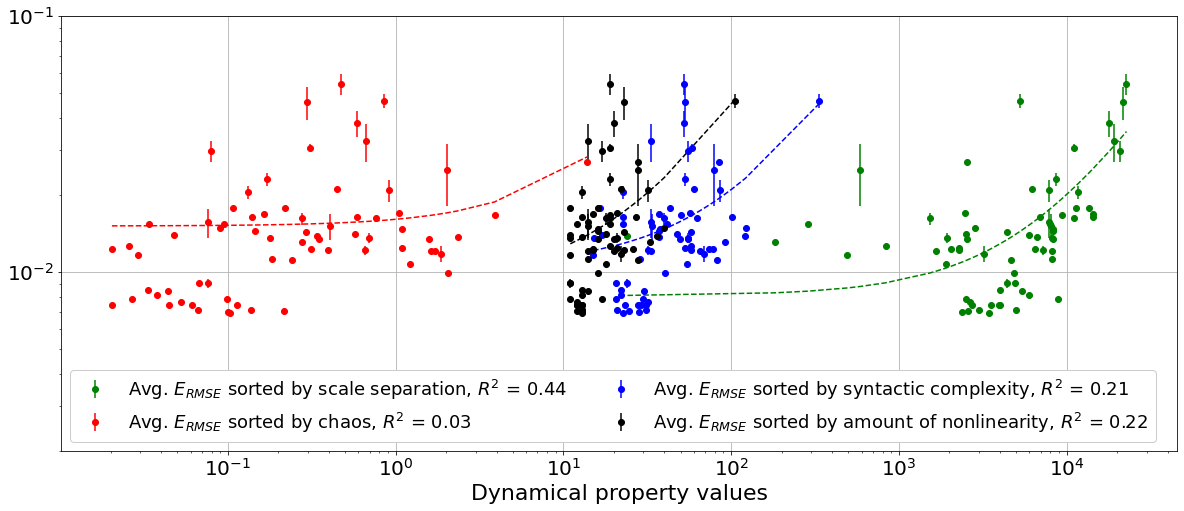

In [13]:
##################
# scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Scale Separation:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="go",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "g--", )

##################
# chaotic levels
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Chaotic Levels:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ro",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "r--", )

##################
# description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Description Length:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="bo",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "b--", )

##################
# amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Amount of Nonlinearity:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ko",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "k--", )

plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.ylim(2e-3, 1e-1)
plt.savefig("model_summary_zero_noise.pdf")

plt.show()

# $\log{(R^2)}$ from scikit-learn without sample weight

In [28]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

In [29]:
# take log of errors
avg_rmse_error = np.log(avg_rmse_error)
cerrs = np.log(cerrs)

Scale Separation:
  [5.74064232e-05] -4.646547394779537
  R^2 value for RMSE error =  0.3903359371287066
  R^2 value for coef error =  -2.2621948302204675
Chaotic Levels:
  [0.06201497] -4.321682432226722
  R^2 value for RMSE error =  0.05025454261430873
  R^2 value for coef error =  -1.7079126457637823
Description Length:
  [0.00512789] -4.53513588965255
  R^2 value for RMSE error =  0.19922673101229016
  R^2 value for coef error =  -1.5590299612799767
Amount of Nonlinearity:
  [0.01733622] -4.607291523810001
  R^2 value for RMSE error =  0.19481311856181505
  R^2 value for coef error =  -1.5735641257948796


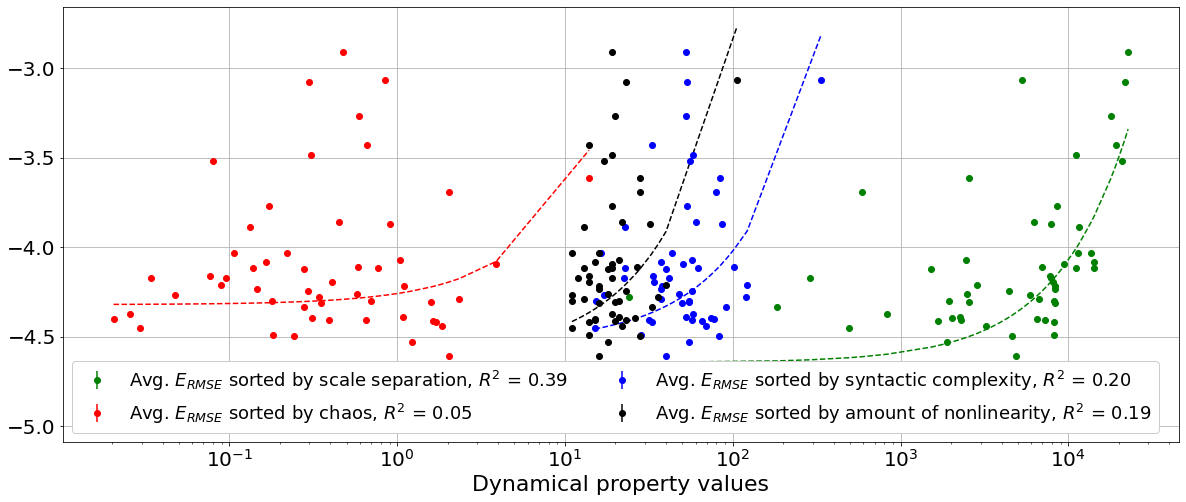

In [30]:
##################
# scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Scale Separation:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="go",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "g--", )

##################
# chaotic levels
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Chaotic Levels:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ro",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "r--", )

# description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Description Length:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="bo",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "b--", )

##################
# amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Amount of Nonlinearity:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ko",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "k--", )

plt.xscale("log")
plt.grid(True)
#plt.yscale('log')
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
#plt.ylim(2e-3, 1e-1)
plt.savefig("model_summary_zero_noise.pdf")

plt.show()

# Log-Log fits now (before it was log(error) but x axis was not log)

In [31]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

In [32]:
# take log of errors
avg_rmse_error = np.log(avg_rmse_error)
cerrs = np.log(cerrs)

0.13373570853537603 -5.394434532554284 0.3164540496057707 0.007609140086486619 0.04861485320491517
R^2 value for RMSE error =  0.1001431655118916
R^2 value for coef error =  0.1988681015001745
0.14289623741584975 -4.074641328663135 0.4205435231509822 0.00028919114940918235 0.03738462868247972
R^2 value for RMSE error =  0.17685685486424071
R^2 value for coef error =  0.06609548684967993
0.41559450819574223 -5.828183796669967 0.4893381475873553 1.717467985080077e-05 0.08981929356679305
R^2 value for RMSE error =  0.2394518226842243
R^2 value for coef error =  0.03313045763570384
0.6310436905429562 -6.075045868503905 0.5056274740241259 8.01632805471363e-06 0.13057506110297087
R^2 value for RMSE error =  0.2556591424880181
R^2 value for coef error =  0.04733081815623574


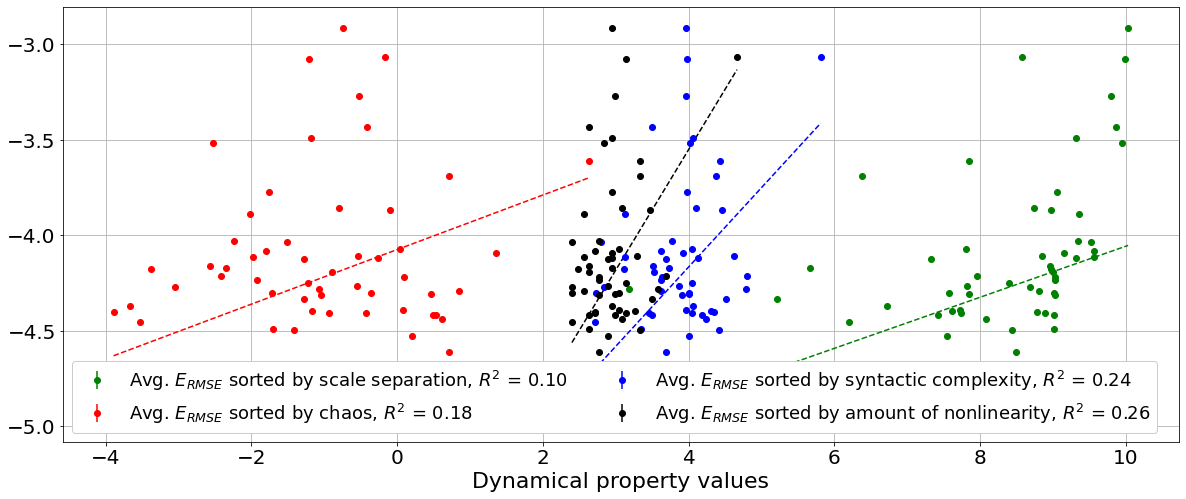

In [34]:
# Repeat the plot, but reorder things by the amount of scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.log(np.sort(scale_list_avg))

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="go",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "g--", )

### now chaos
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.log(np.sort(lyap_list))
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

#plt.figure(figsize=(20, 2))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ro",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "r--", )

### now description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.log(np.array(np.sort(medl_list), dtype=float))
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

#plt.figure(figsize=(20, 2))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="bo",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "b--", )

### now amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.log(np.array(np.sort(nonlinear_sum), dtype=float))
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

#plt.figure(figsize=(20, 2))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ko",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "k--", )

#plt.xscale("log")
plt.grid(True)
#plt.yscale('log')
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.savefig("model_summary_zero_noise.pdf")

plt.show()

# $R^2$ from scikit-learn with sample weight

**Note: Can't apply weights to coef regression because coef std is too small.**

In [35]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
std_coef_error = np.zeros(num_attractors)
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    #std_rmse_error[i] = np.std(abs(coef_avg_error[i]))
    
# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

Scale Separation:
  [1.08148222e-06] 0.018452448370743654
  R^2 value for RMSE error =  -0.5943513740922419
  R^2 value for coef error =  0.04969909057072586
Chaotic Levels:
  [-0.00162549] 0.033819695434974886
  R^2 value for RMSE error =  -3.364528780439456
  R^2 value for coef error =  -0.08562125831105516
Description Length:
  [4.98633209e-05] 0.02902333224281524
  R^2 value for RMSE error =  -2.6037760086400152
  R^2 value for coef error =  0.06339453622642455
Amount of Nonlinearity:
  [0.00017374] 0.028118937398412723
  R^2 value for RMSE error =  -2.561694260006706
  R^2 value for coef error =  0.057884176842889934


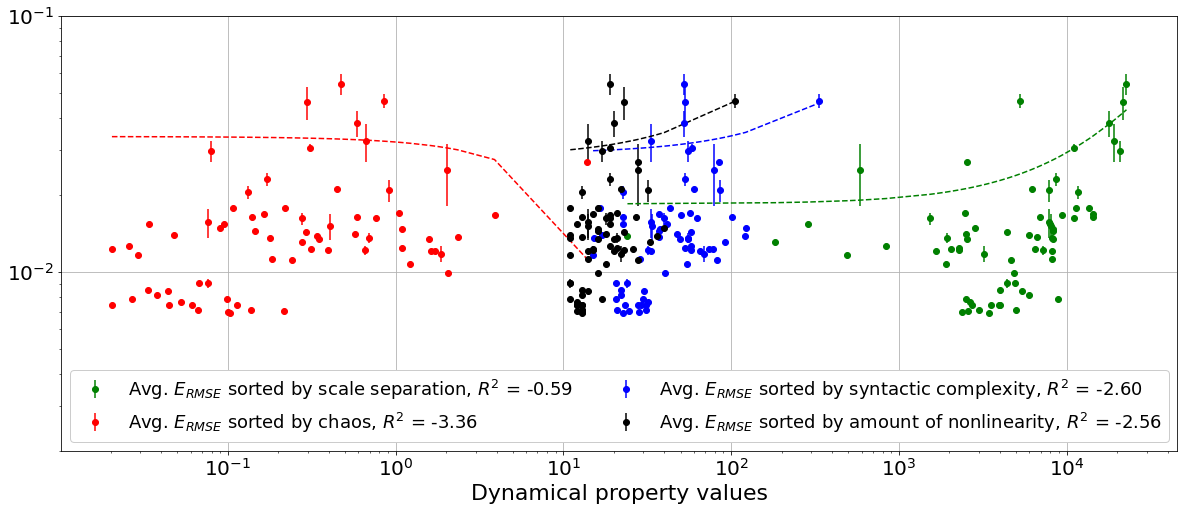

In [36]:
##################
# scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Scale Separation:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="go",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "g--", )

##################
# chaotic levels
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Chaotic Levels:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ro",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "r--", )

##################
# description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Description Length:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="bo",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "b--", )

##################
# amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Amount of Nonlinearity:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ko",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "k--", )

plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.ylim(2e-3, 1e-1)
plt.savefig("model_summary_zero_noise.pdf")

plt.show()

# $\log{(R^2)}$ from scikit-learn with sample weight

In [40]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_error[attractor_name]))))
# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

In [41]:
# take log of errors
avg_rmse_error = np.log(avg_rmse_error)
cerrs = np.log(cerrs)

Scale Separation:
  [3.62799364e-05] -3.989399599494435
  R^2 value for RMSE error =  -0.8439840330567312
  R^2 value for coef error =  -2.2621948302204675
Chaotic Levels:
  [-0.04091557] -3.484841160746583
  R^2 value for RMSE error =  -2.6252399821175167
  R^2 value for coef error =  -1.7079126457637823
Description Length:
  [0.00167401] -3.6348724395034075
  R^2 value for RMSE error =  -2.1873839396795454
  R^2 value for coef error =  -1.5590299612799767
Amount of Nonlinearity:
  [0.00584648] -3.6655821365983514
  R^2 value for RMSE error =  -2.1642971829722484
  R^2 value for coef error =  -1.5735641257948796


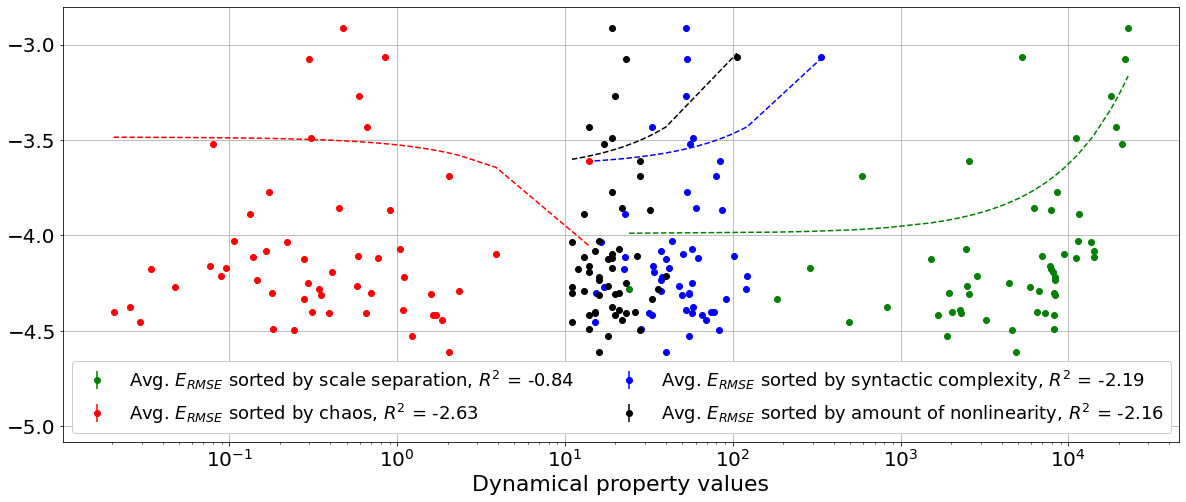

In [43]:
##################
# scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Scale Separation:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="go",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "g--", )

##################
# chaotic levels
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Chaotic Levels:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ro",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "r--", )

##################
# description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Description Length:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="bo",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "b--", )

##################
# amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)

regr_rmse = linear_model.LinearRegression()
regr_rmse.fit(scale_list_sorted.reshape(-1, 1), avg_rmse_error[scale_sort], std_rmse_error[scale_sort])
r_value = r2_score(avg_rmse_error[scale_sort], regr_rmse.predict(scale_list_sorted.reshape(-1, 1)))

regr_coef = linear_model.LinearRegression()
regr_coef.fit(scale_list_sorted.reshape(-1, 1), cerrs[scale_sort])
r_value_coef = r2_score(avg_rmse_error[scale_sort], regr_coef.predict(scale_list_sorted.reshape(-1, 1)))

print("Amount of Nonlinearity:")
print(" ", regr_rmse.coef_, regr_rmse.intercept_)
print("  R^2 value for RMSE error = ", r_value)
print("  R^2 value for coef error = ", r_value_coef)

plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ko",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value)
)
plt.plot(scale_list_sorted, regr_rmse.coef_ * scale_list_sorted + regr_rmse.intercept_, "k--", )

plt.xscale("log")
plt.grid(True)
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.savefig("model_summary_zero_noise.pdf")

plt.show()

# Pareto curve 

In [25]:
temp = open('xdot_rmse_pareto_ave.json')
xdot_rmse_pareto_ave = json.load(temp)

temp = open('xdot_rmse_pareto_std.json')
xdot_rmse_pareto_std = json.load(temp)

In [26]:
temp = open('threshold_values.json')
threshold_values = json.load(temp)

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


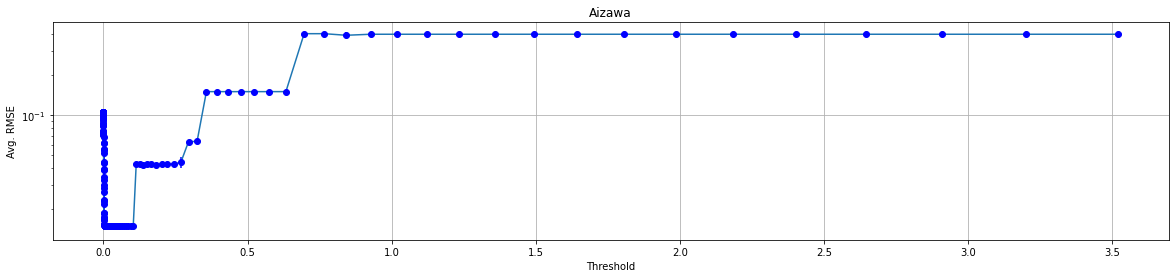

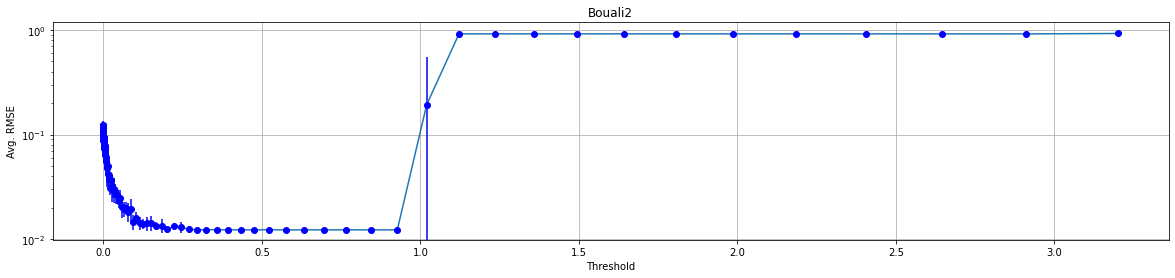

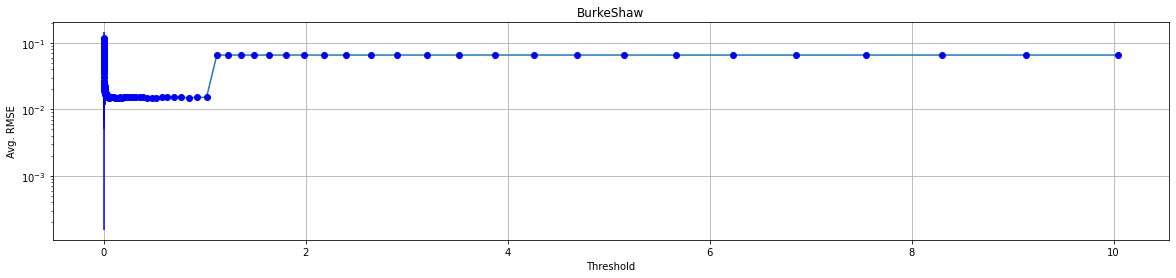

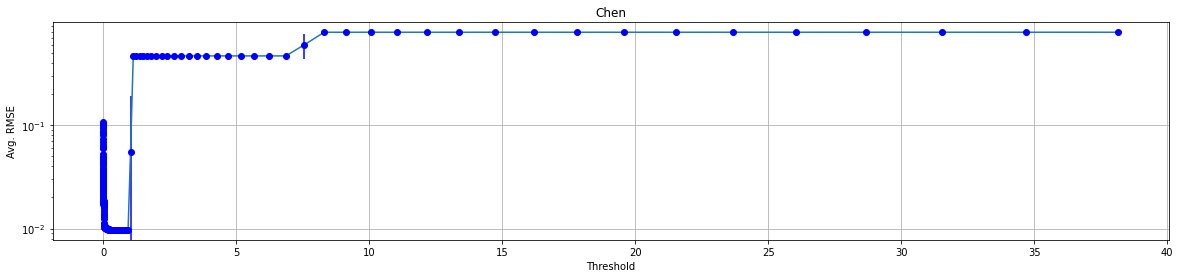

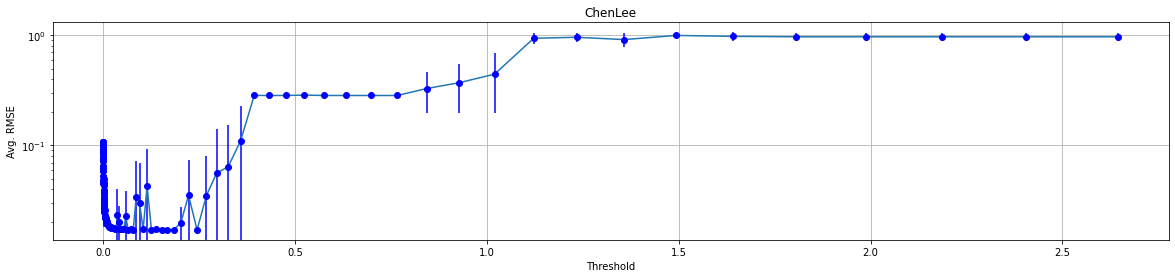

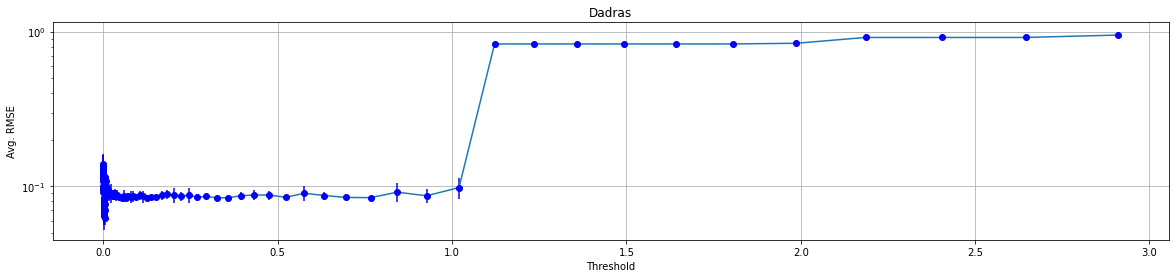

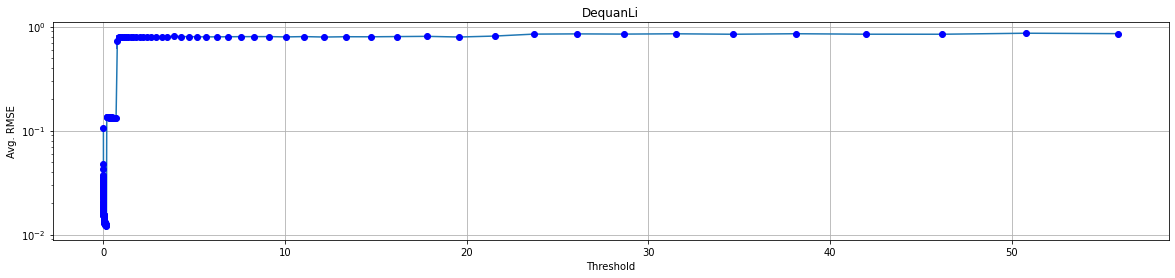

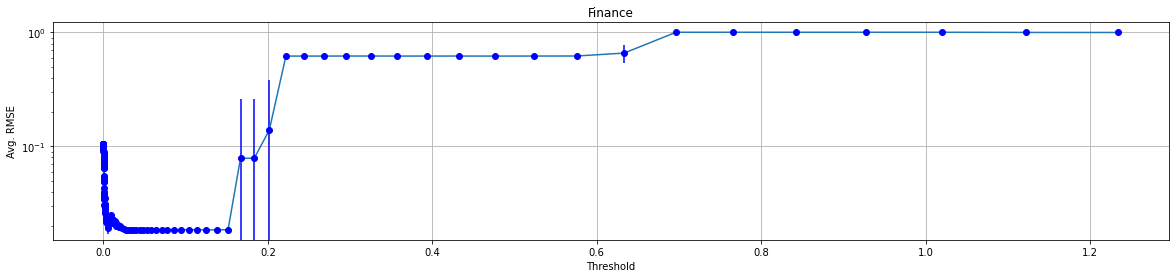

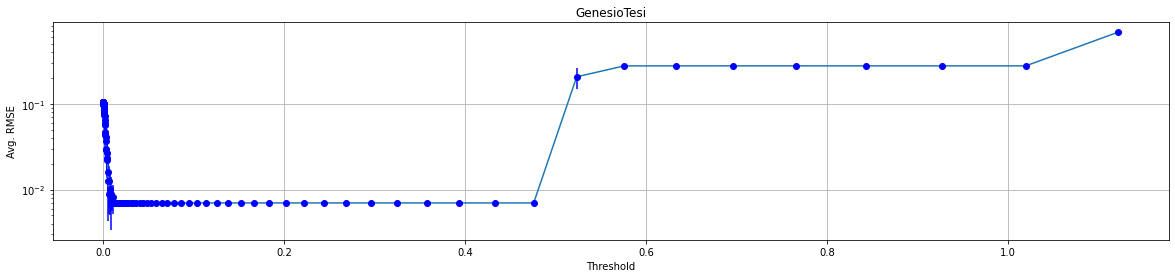

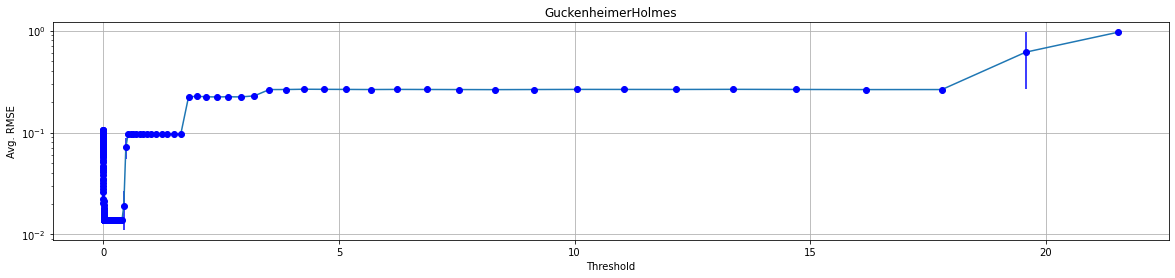

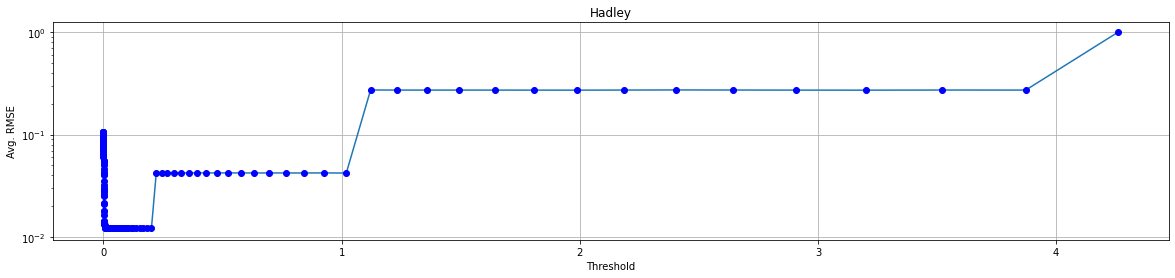

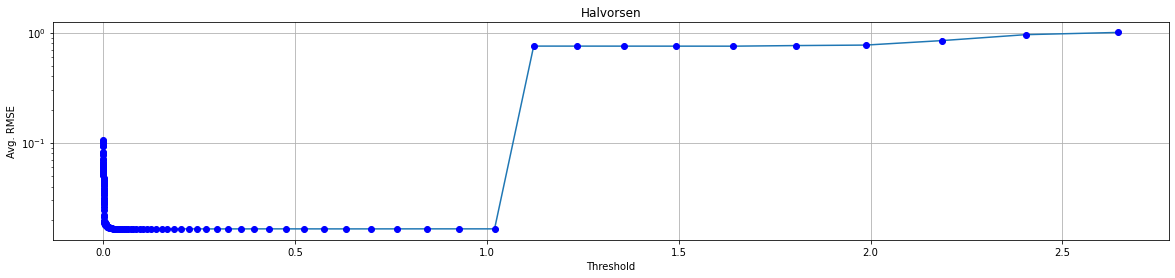

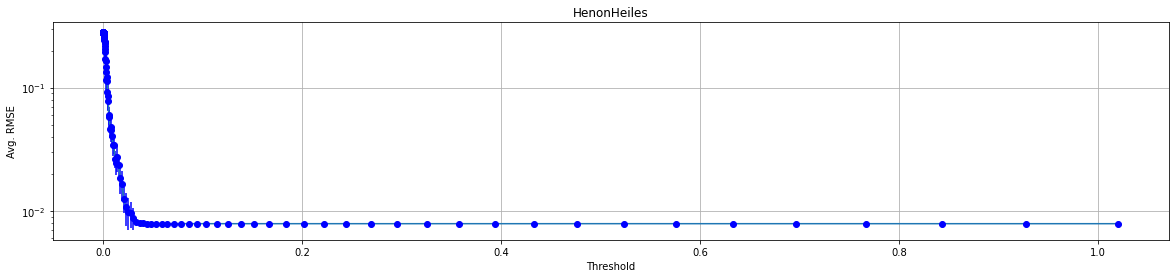

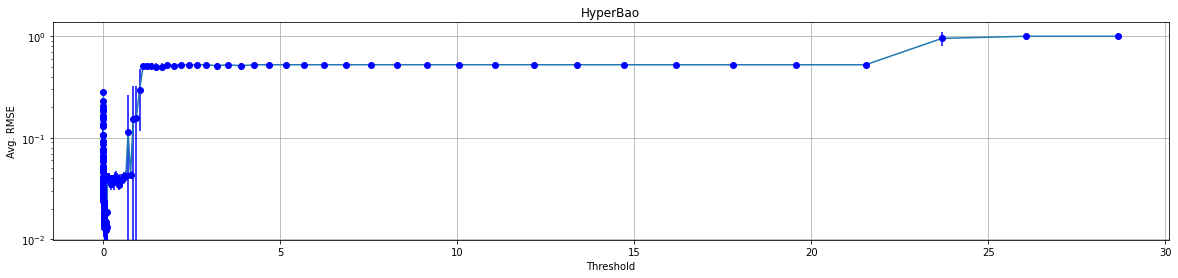

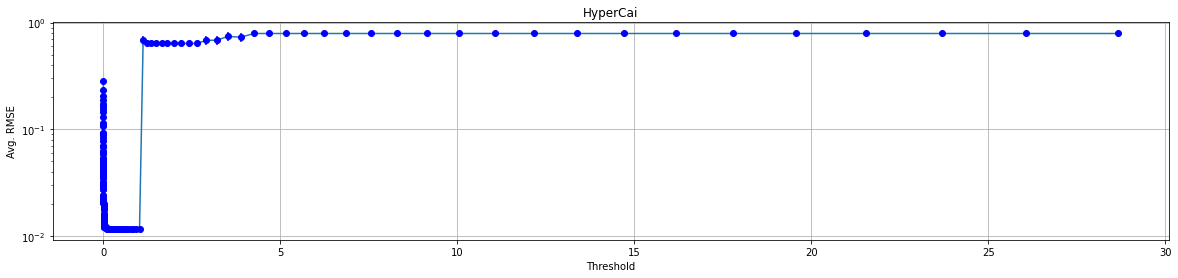

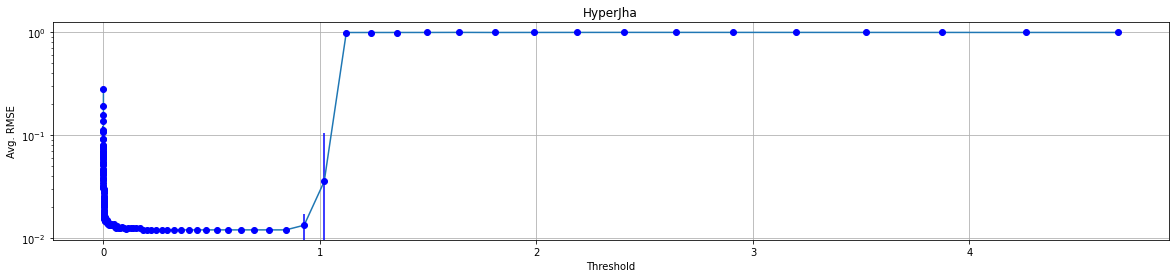

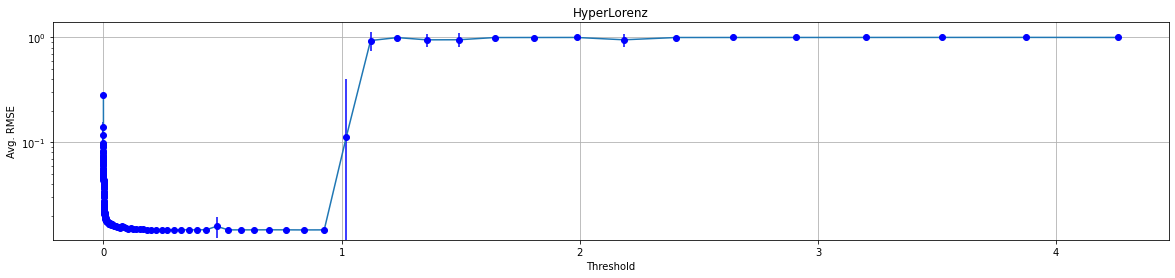

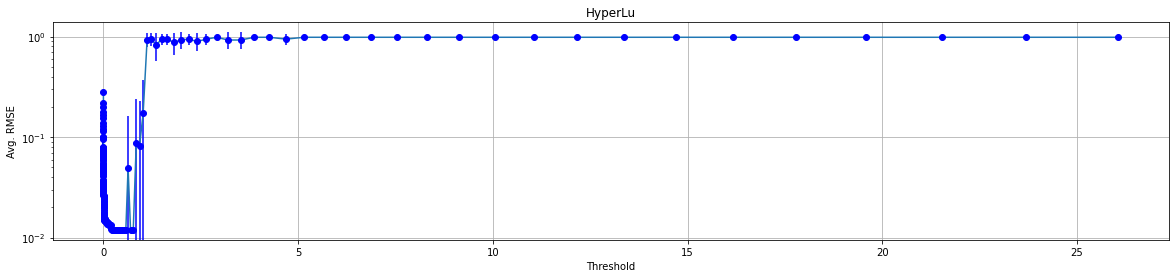

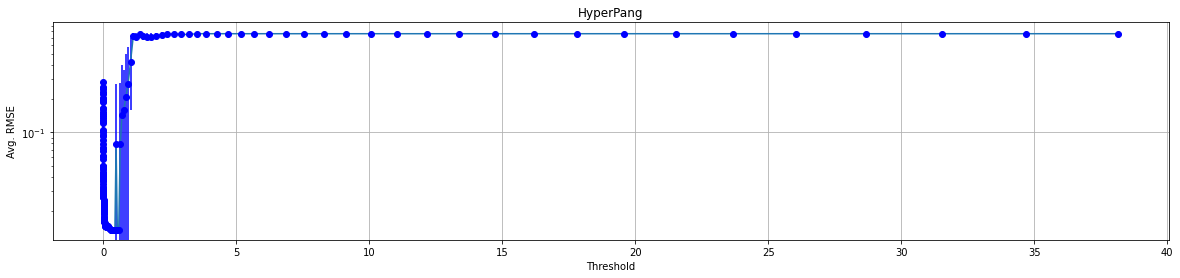

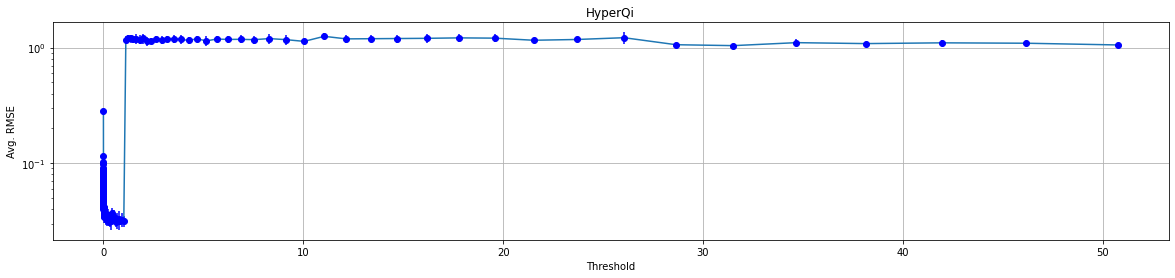

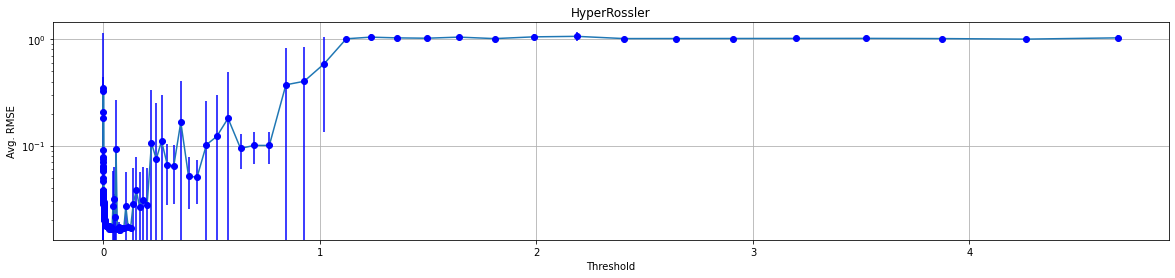

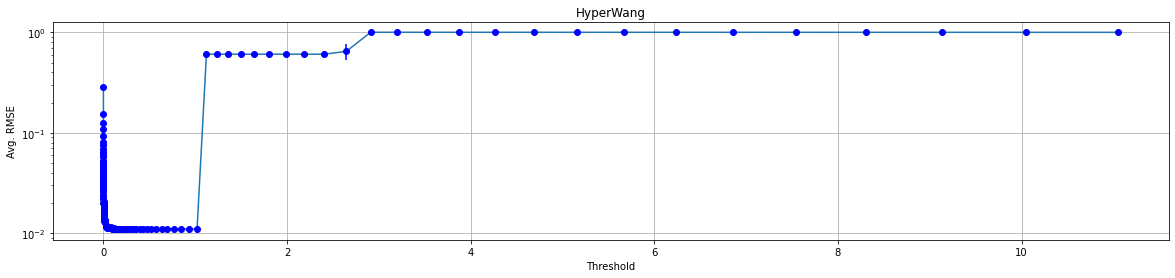

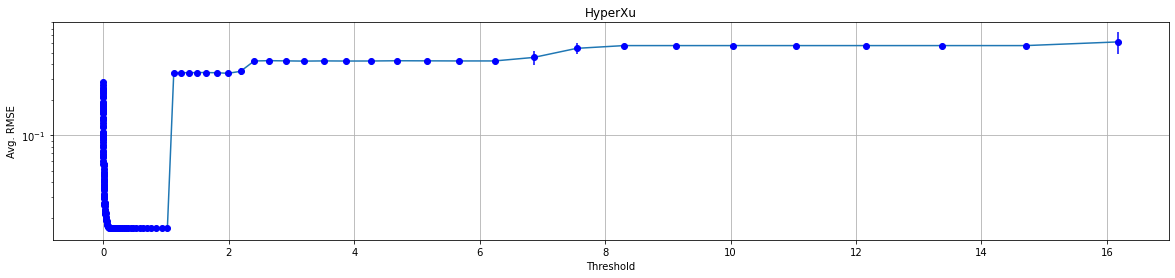

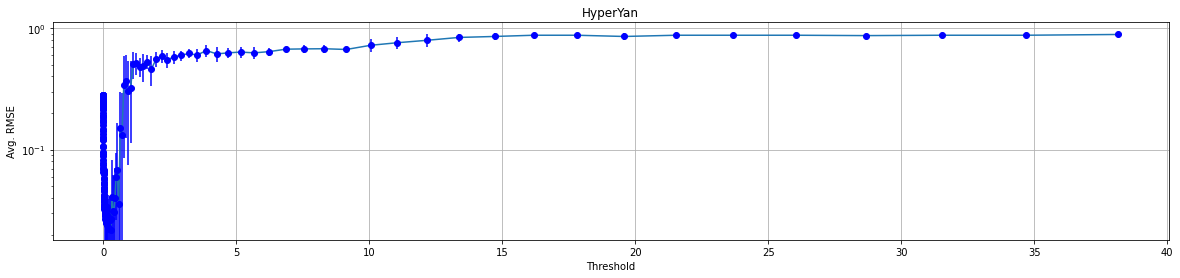

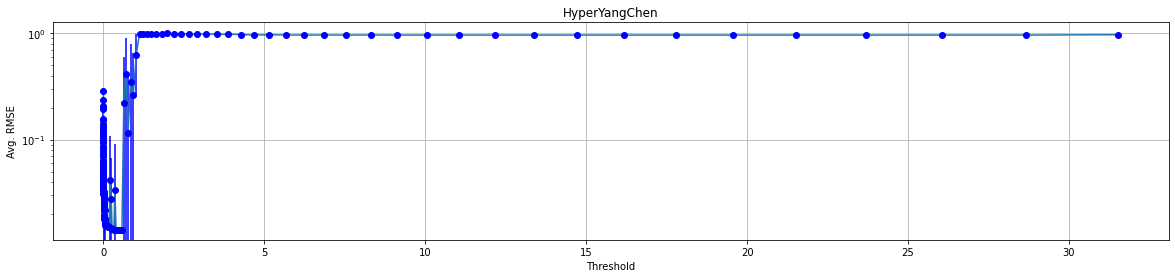

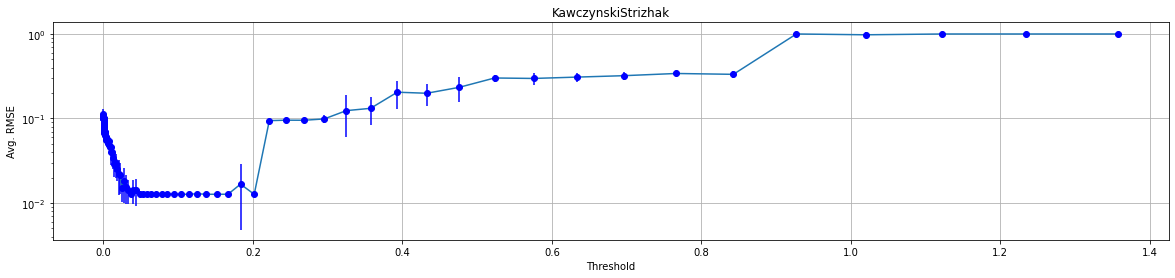

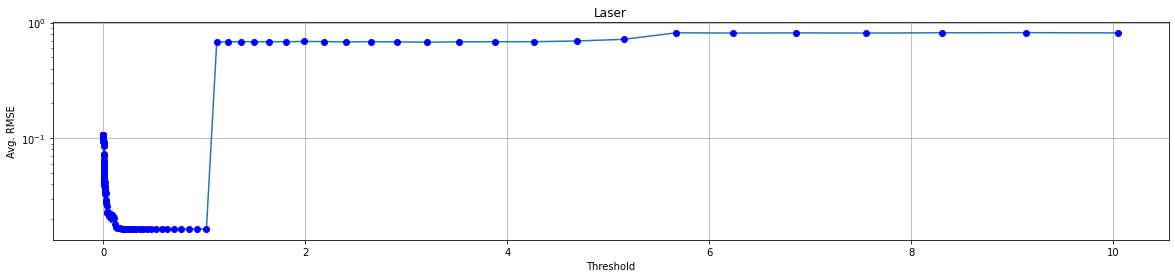

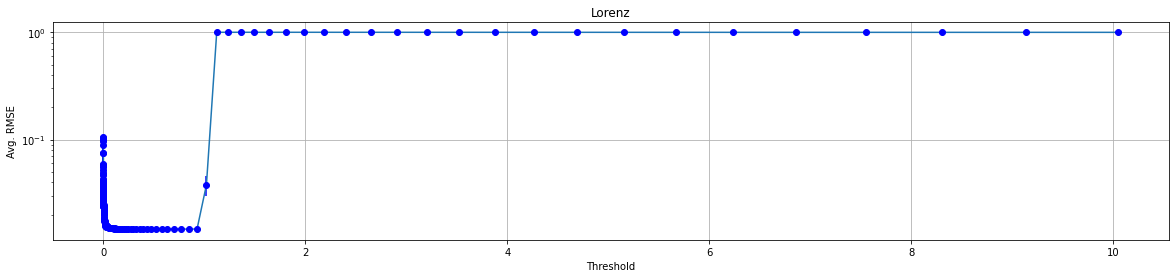

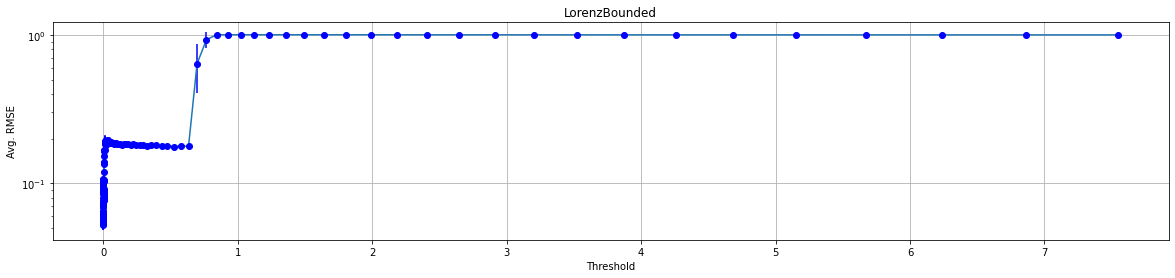

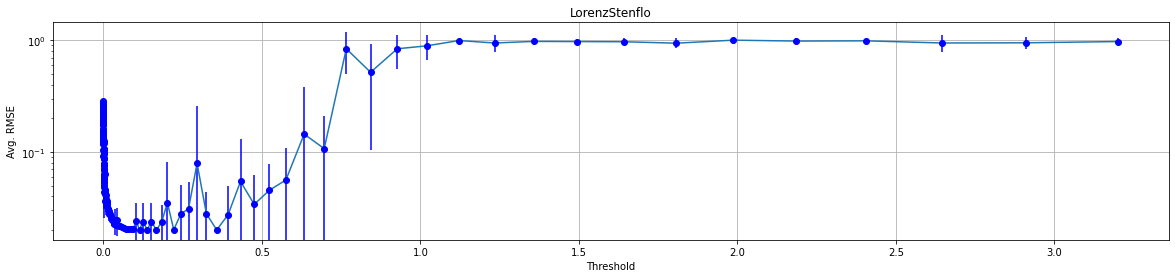

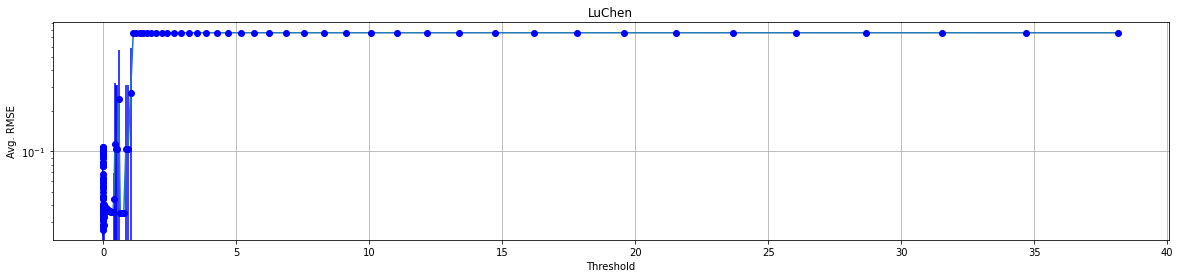

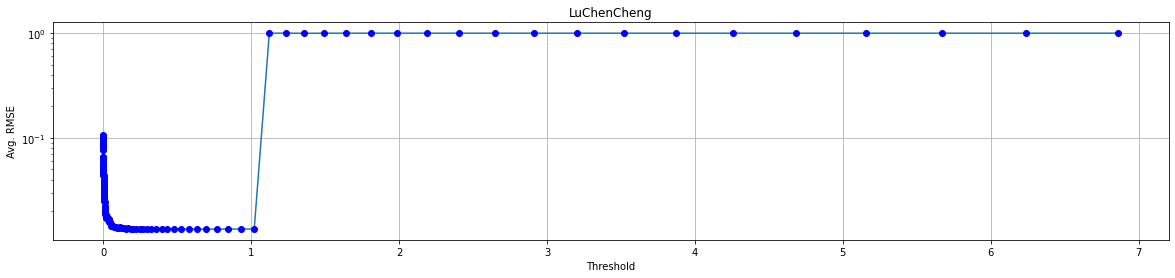

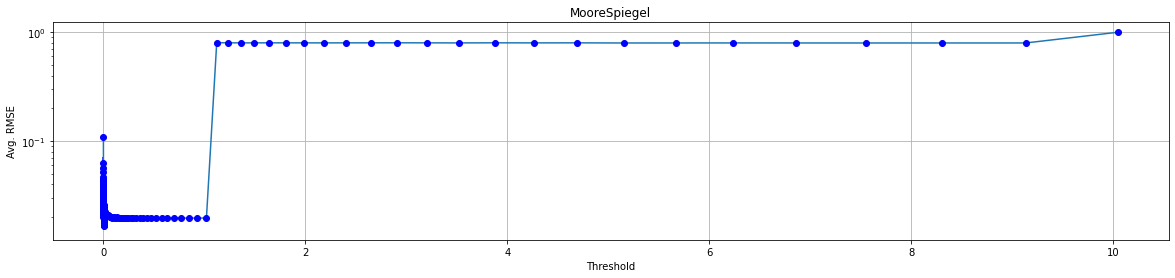

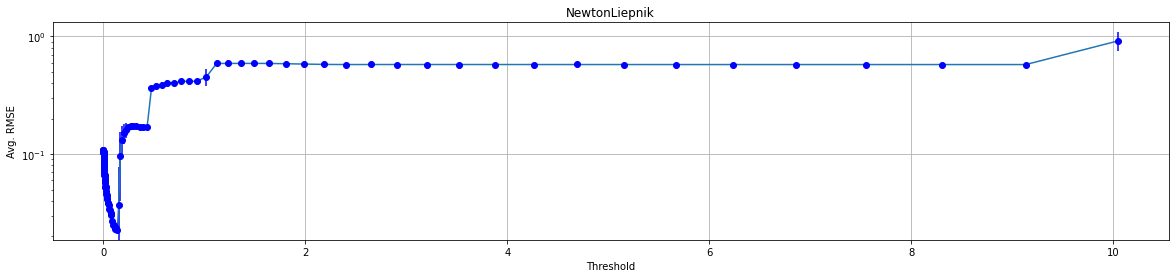

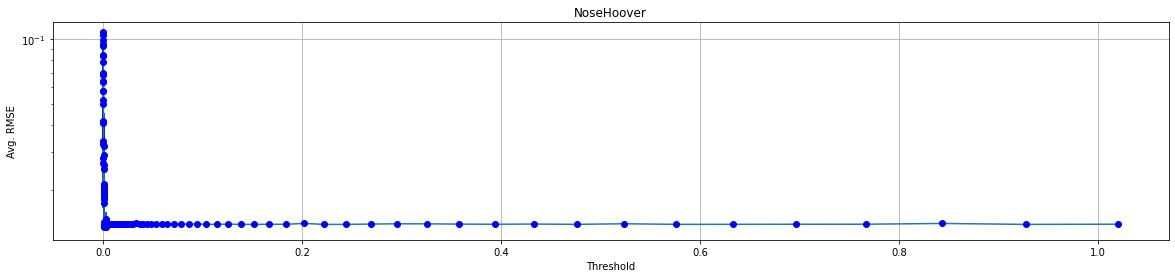

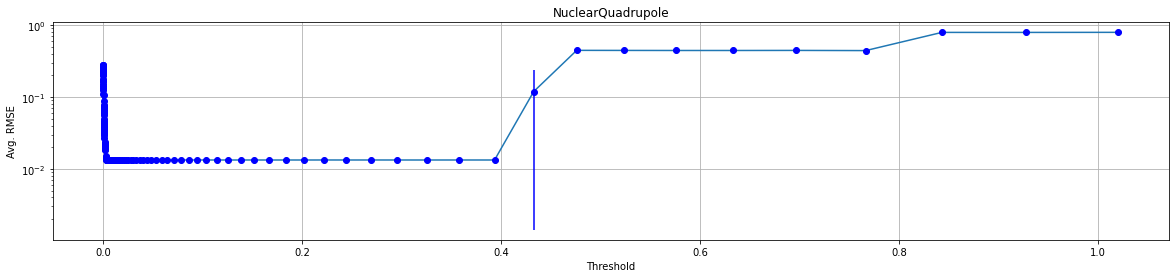

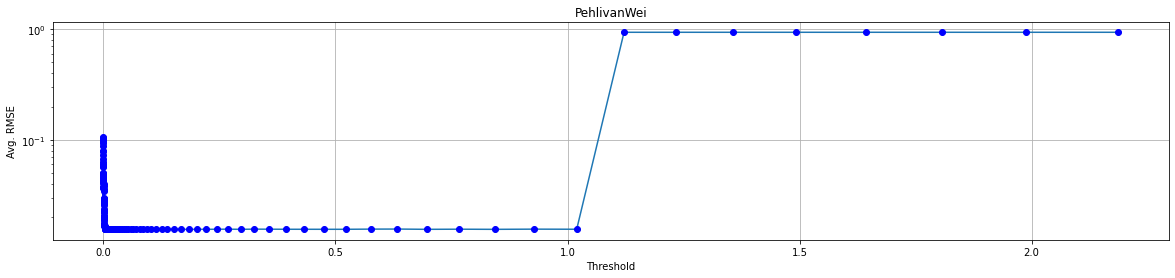

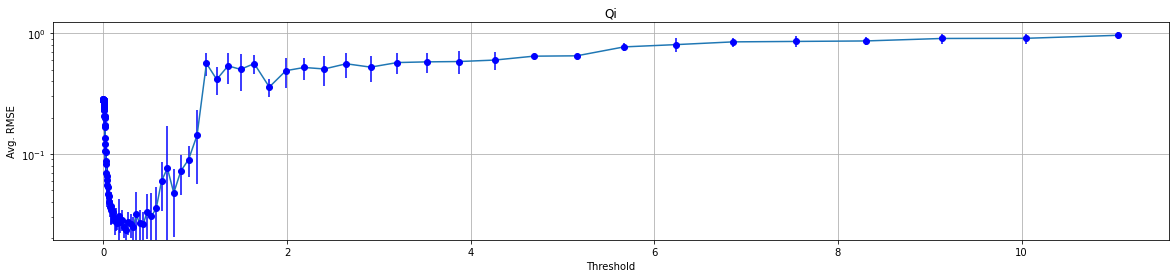

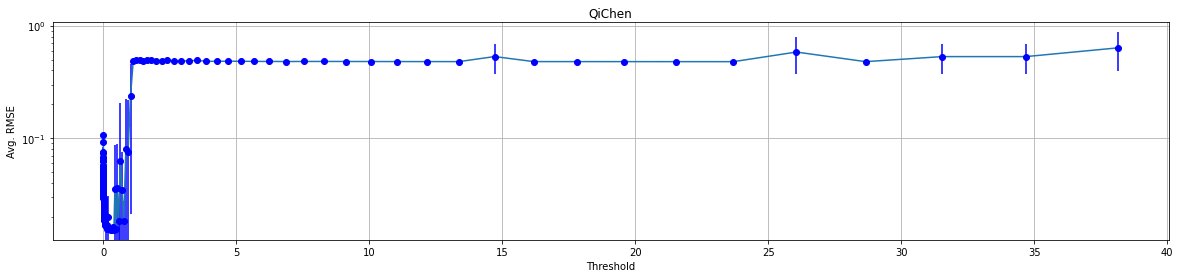

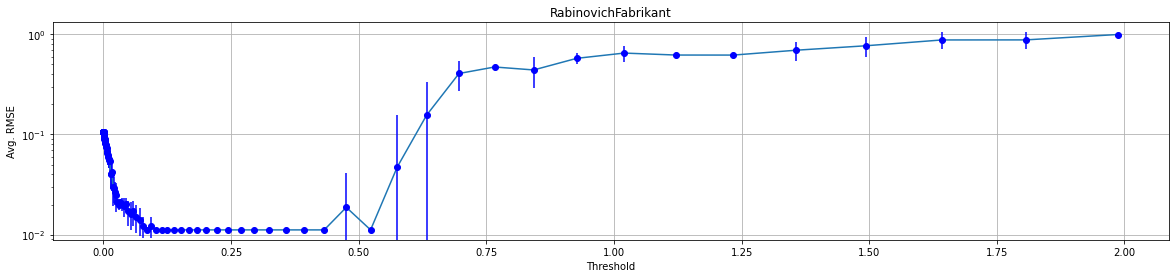

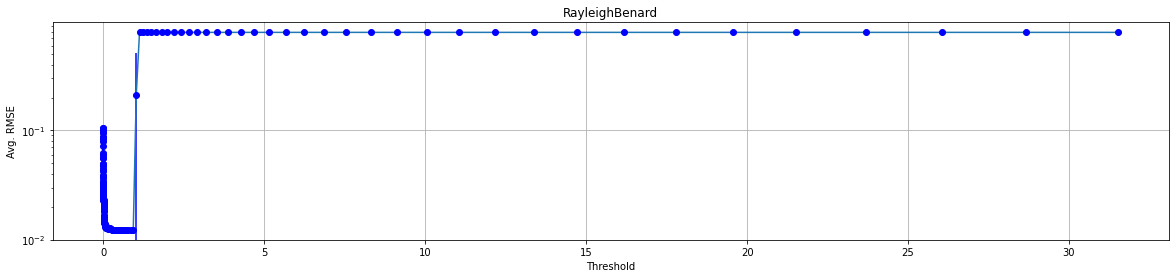

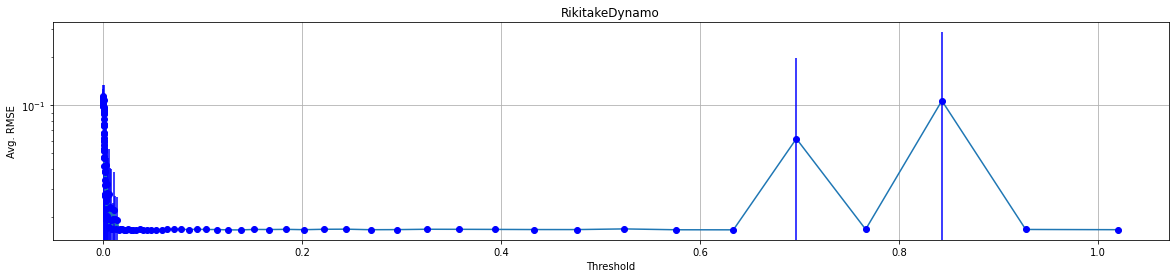

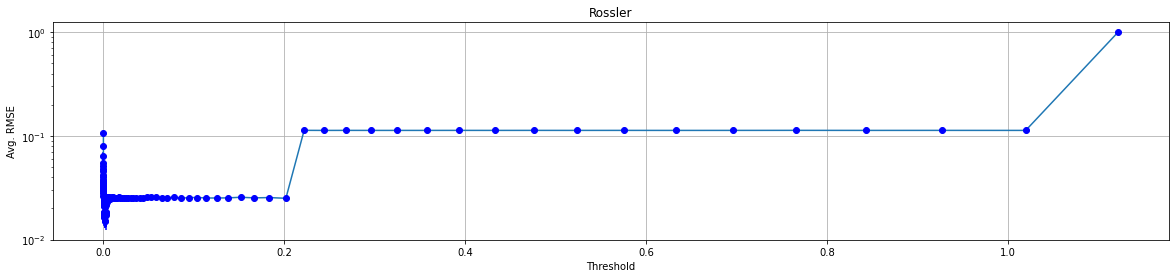

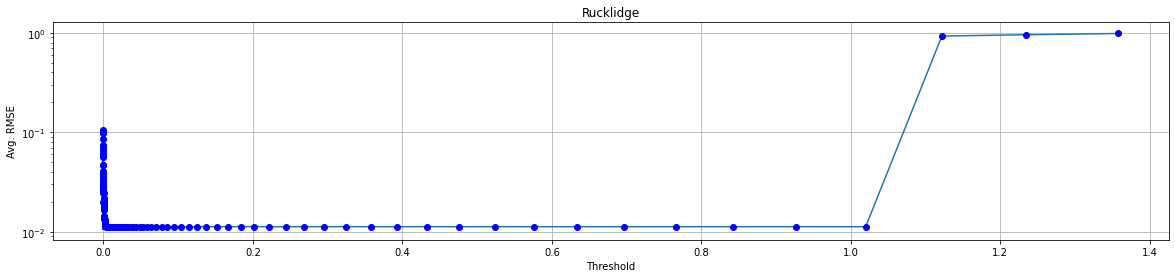

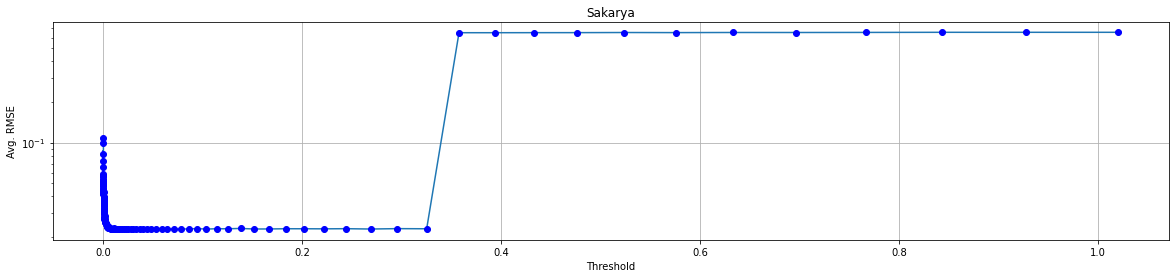

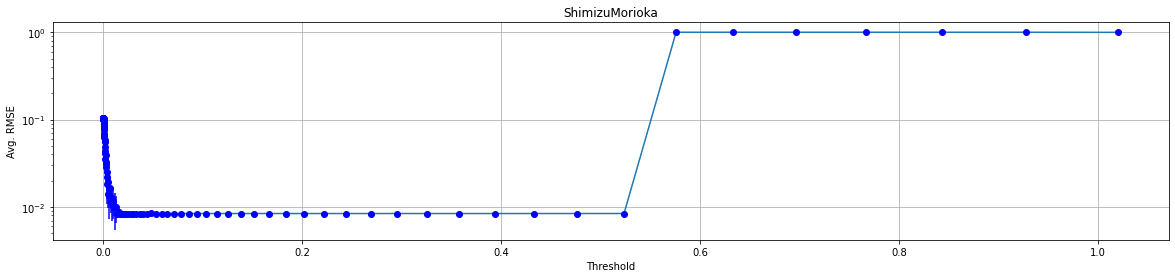

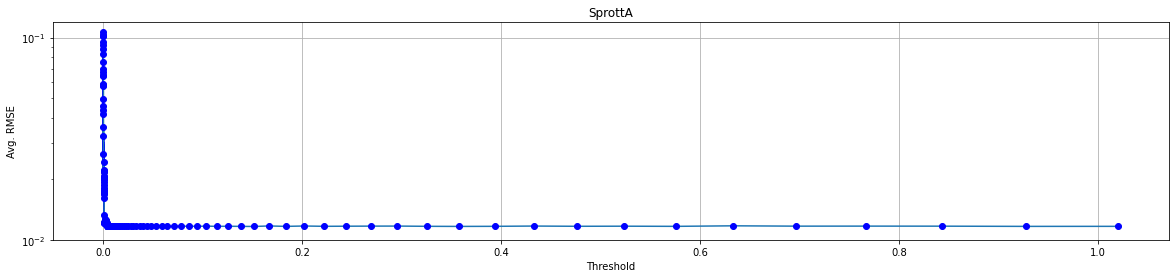

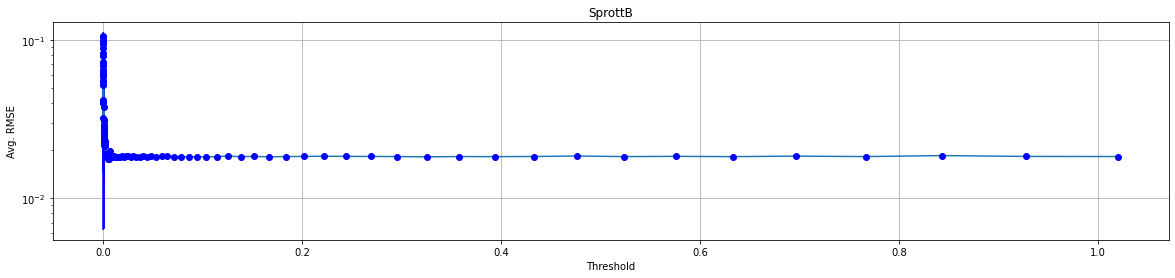

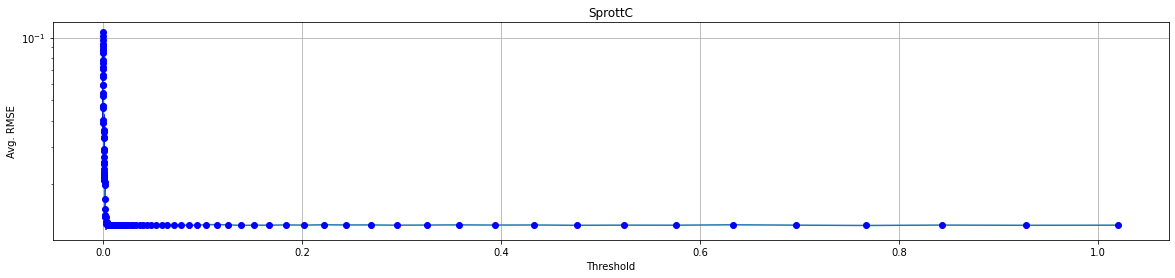

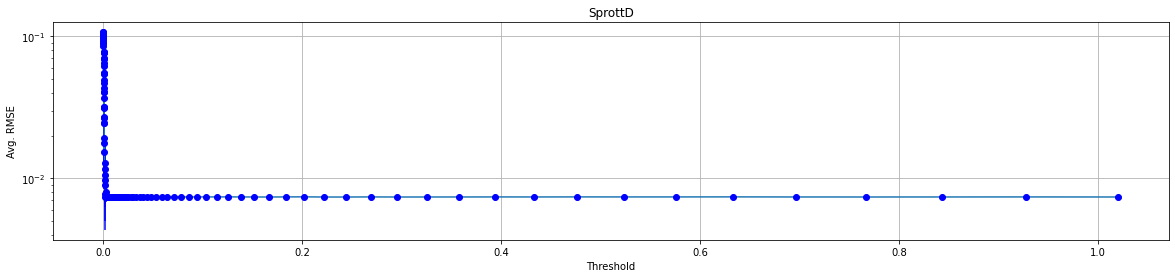

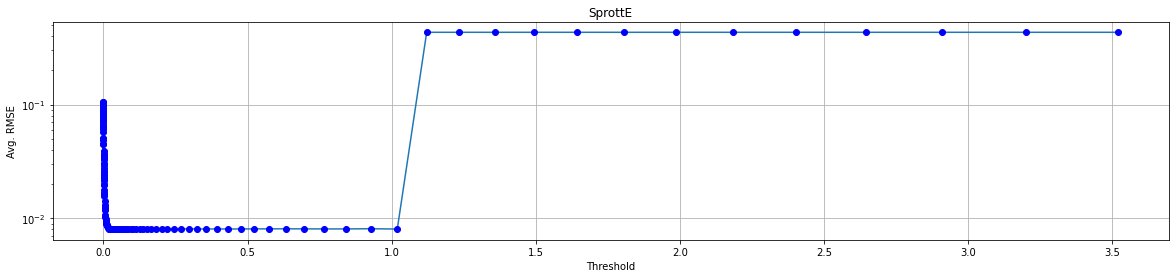

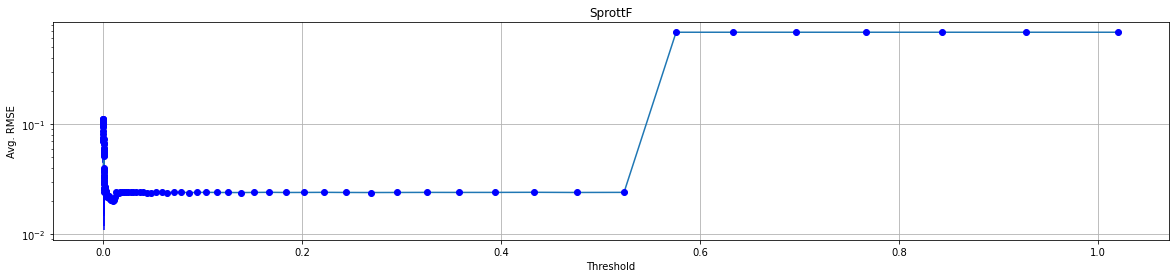

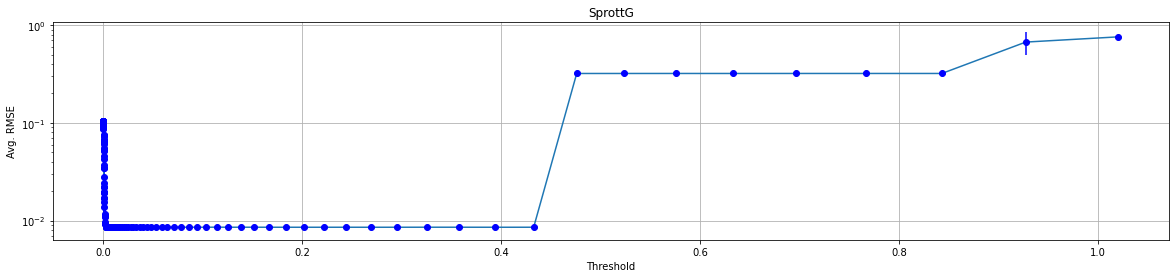

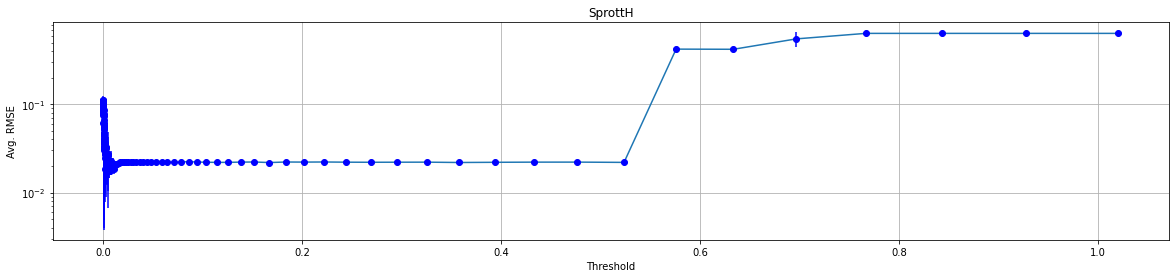

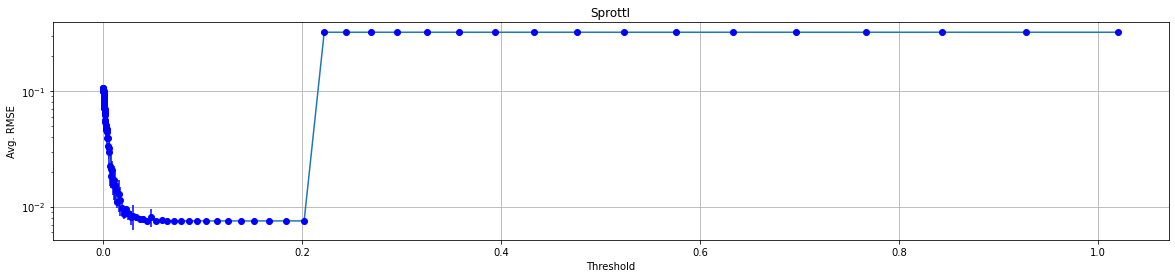

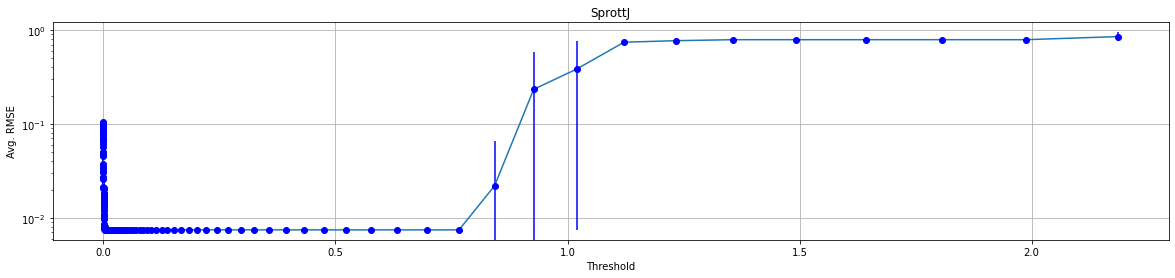

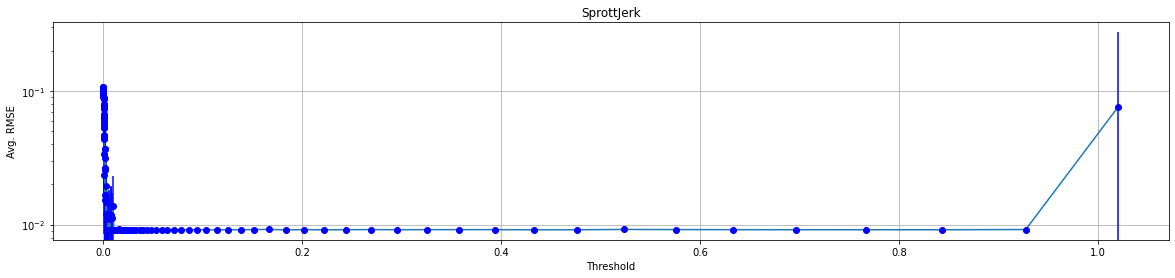

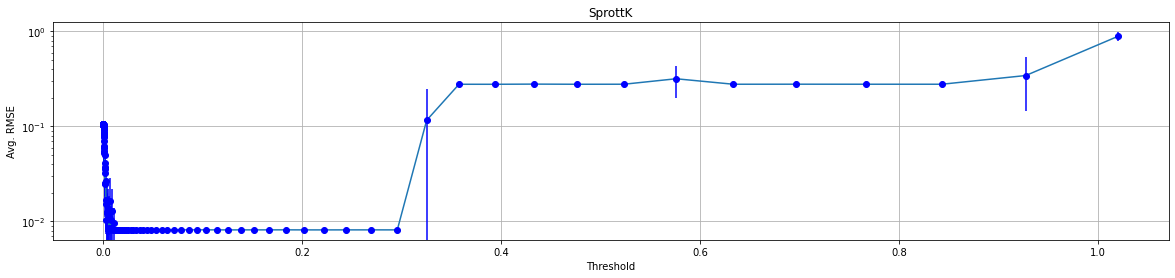

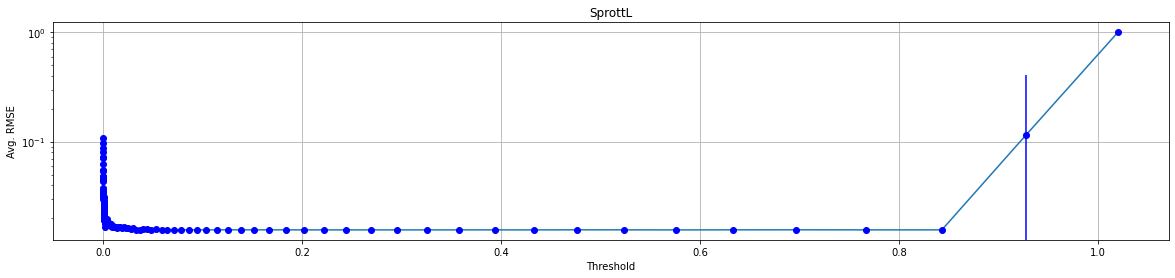

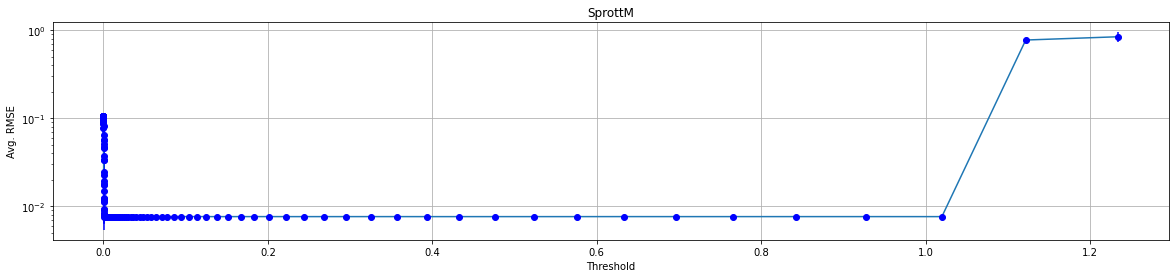

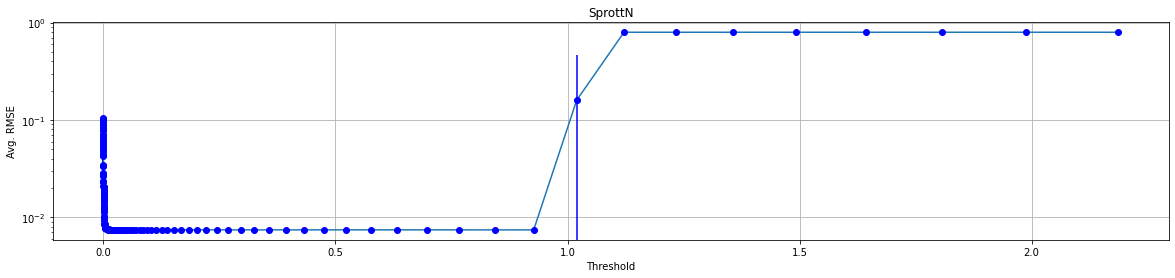

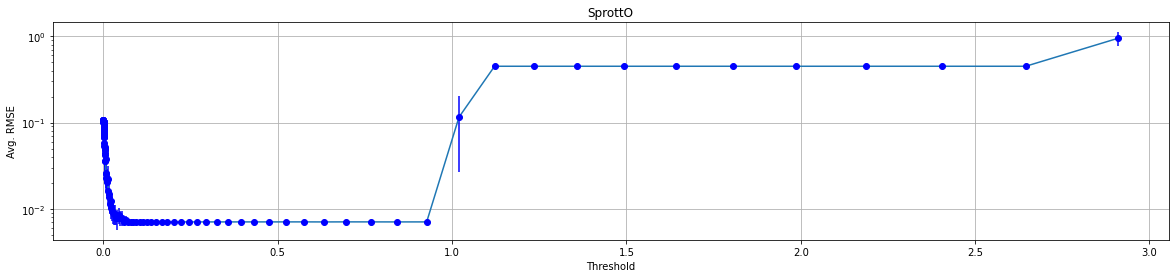

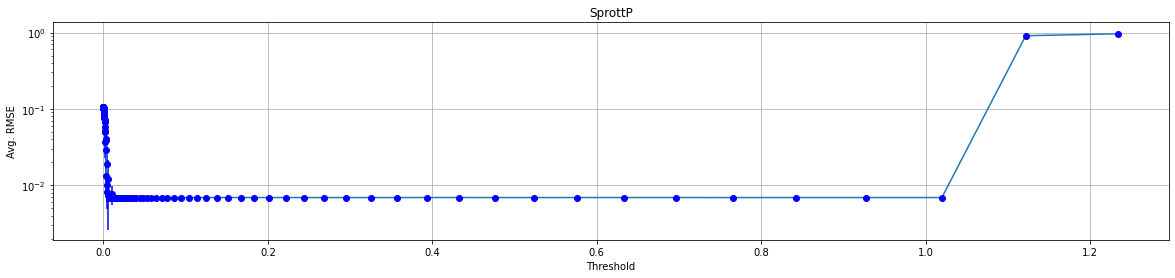

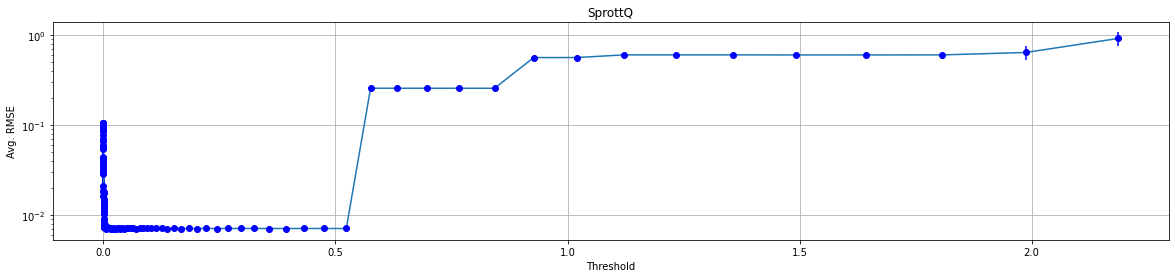

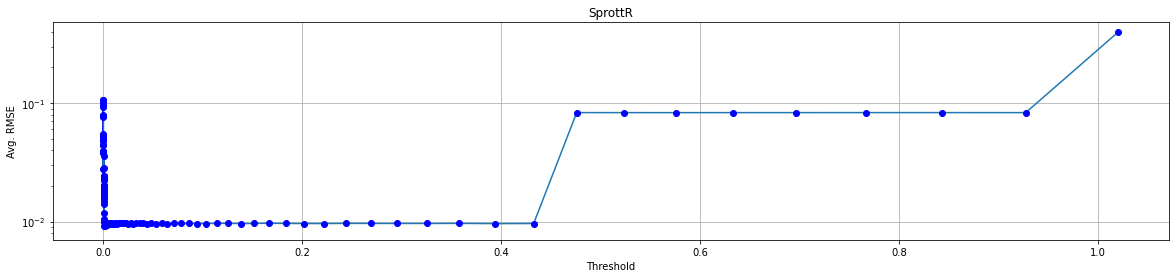

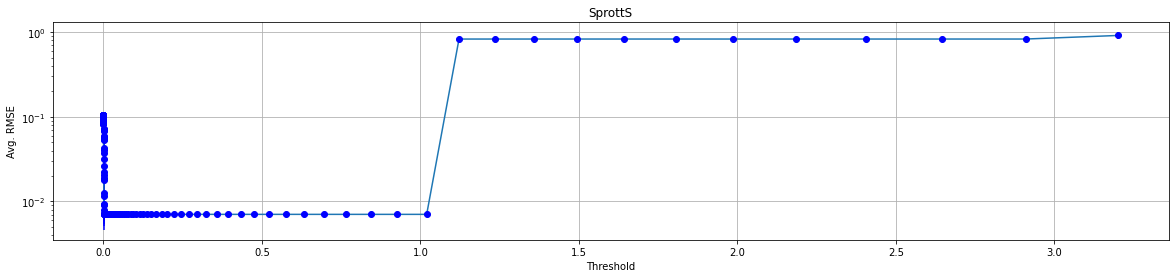

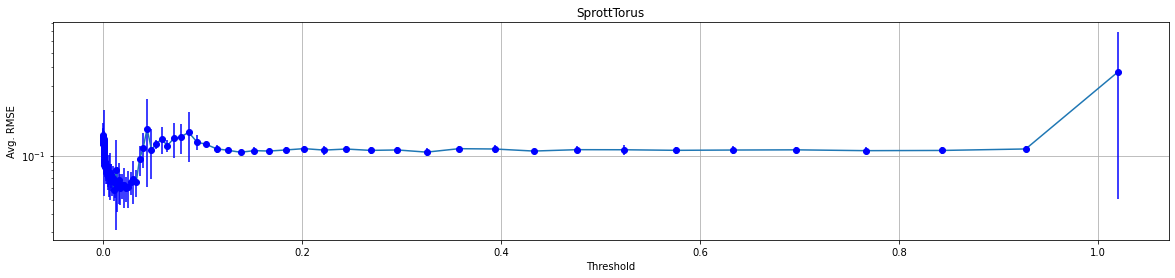

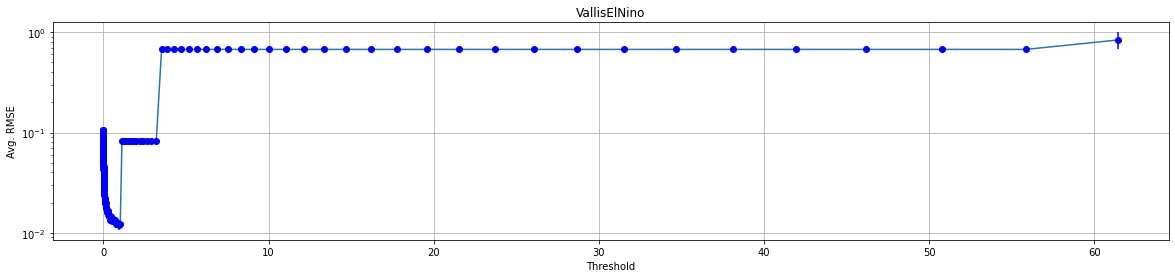

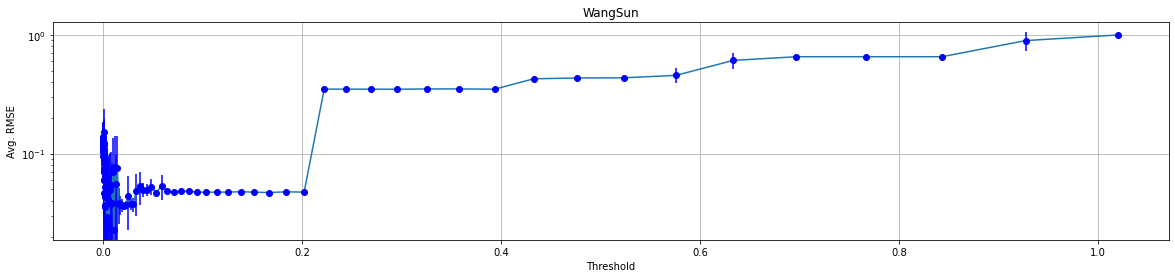

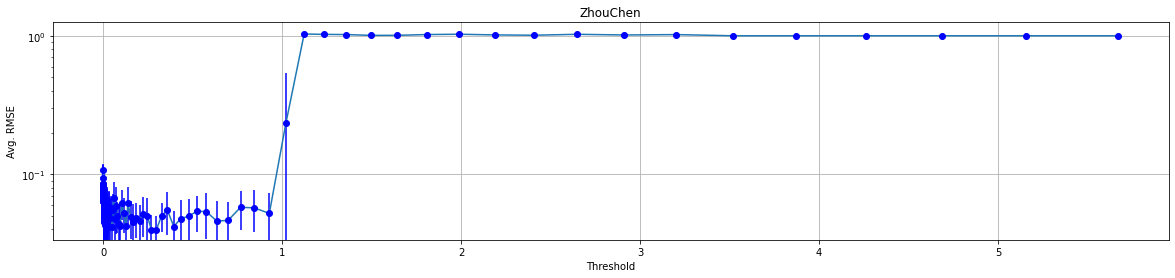

In [27]:
for i, system in enumerate(systems_list):
    curr_ave = xdot_rmse_pareto_ave[system]
    curr_std = xdot_rmse_pareto_std[system]
    curr_tol = threshold_values[system][0]
    
    plt.figure(1 + i, figsize=(20, 4))
    plt.errorbar(curr_tol, curr_ave, curr_std, fmt="bo",)
    plt.plot(curr_tol, curr_ave,)
    plt.title(system)
    plt.ylabel("Avg. RMSE")
    plt.yscale('log')
    plt.xlabel("Threshold")
    plt.grid()